----------------------------
# **Creación del Modelo y Evalución**
------------------------ 

-------------------
------------------
## **1.** **Importar Librerias**
-------------------
------------------

In [22]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout

-------------------
------------------
## **2.** **Cargar Datos Procesados**
-------------------
------------------

In [23]:
# Load Processed Data
movies_path = '../Data/Processed/processed_movies.csv'
movies = pd.read_csv(movies_path)

-------------------
------------------
## **3.** **Preprocesamiento de Emociones**
-------------------
------------------

In [24]:
# Emotion Preprocessing
movies['emotions_list'] = movies['emotions'].apply(lambda x: eval(x))

# Binarize the emotions
mlb = MultiLabelBinarizer()
emotions_binarized = mlb.fit_transform(movies['emotions_list'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(emotions_binarized, movies['average_rating'], test_size=0.2, random_state=42)

-------------------
------------------
## **4.** **Definir el Modelo**
-------------------
------------------

In [25]:
# Define the model
input_layer = Input(shape=(emotions_binarized.shape[1],))
embedding_layer = Dense(128, activation='relu')(input_layer)
x = Flatten()(embedding_layer)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(1, activation='linear')(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

-------------------
------------------
## **5.** **Entrenamiento del Modelo**
-------------------
------------------

In [26]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1.3954 - mae: 0.8327 - val_loss: 0.3940 - val_mae: 0.4776
Epoch 2/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.4658 - mae: 0.5247 - val_loss: 0.3962 - val_mae: 0.4819
Epoch 3/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.4732 - mae: 0.5242 - val_loss: 0.4004 - val_mae: 0.4830
Epoch 4/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.4608 - mae: 0.5211 - val_loss: 0.3951 - val_mae: 0.4765
Epoch 5/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.4629 - mae: 0.5232 - val_loss: 0.3983 - val_mae: 0.4770
Epoch 6/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.4559 - mae: 0.5157 - val_loss: 0.3938 - val_mae: 0.4706
Epoch 7/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.4506 - mae: 0.5104 - val_loss: 0.4085 - val_mae: 0.4973
Epoch 8/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.4516 - mae: 0.5126 - val_loss: 0.4074 - val_mae: 0.4675
Epoch 9/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - l

-------------------
------------------
## **6.** **Guardar el Modelo**
-------------------
------------------

In [27]:
model.save('../Models/movie_recommender_model_3.keras')

-------------------
------------------
## **7.** **Visualizar el Proceso de Entrenamiento**
-------------------
------------------

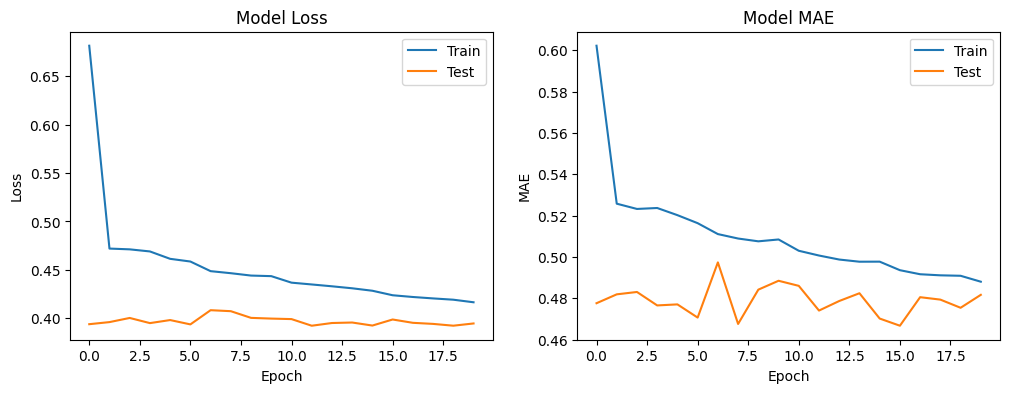

In [28]:
# Visualize the Training Process
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(['Train', 'Test'], loc='upper right')

plt.show()

-------------------
------------------
## **8.** **Evaluación del Modelo**
-------------------
------------------

In [29]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f'Model Loss: {loss}, Model MAE: {mae}')

# Calculate the mean value of y_test
y_test_mean = np.mean(y_test)

# Convert the loss to a percentage of the mean value of y_test
loss_percentage = (loss / y_test_mean) * 100

# Convert the MAE to a percentage of the mean value of y_test
mae_percentage = (mae / y_test_mean) * 100

print(f'Model Loss: {loss} ({loss_percentage:.2f}%)')
print(f'Model MAE: {mae} ({mae_percentage:.2f}%)')

169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3848 - mae: 0.4765
Model Loss: 0.39476653933525085, Model MAE: 0.4816376268863678
Model Loss: 0.39476653933525085 (12.55%)
Model MAE: 0.4816376268863678 (15.31%)


-------------------
------------------
## **9.** **Función de Recomendación Mejorada**
-------------------
------------------

In [30]:
def recommend_movies_embedding(emotion1, emotion2, movies=movies, mlb=mlb, model=model, top_n=10):
    emotions = [emotion1, emotion2]
    binarized_emotions = mlb.transform([emotions])
    predicted_rating = model.predict(binarized_emotions)[0][0]
    
    # Find movies with ratings close to the prediction
    movies['rating_diff'] = abs(movies['average_rating'] - predicted_rating)
    recommended_movies = movies.sort_values(by=['rating_diff', 'average_rating'], ascending=[True, False]).head(top_n)
    
    return recommended_movies[['title', 'average_rating']]

# Example recommendation
print("Recomendaciones para las emociones 'Joy' y 'Fear':")
print(recommend_movies_embedding('Joy', 'Fear'))

Recomendaciones para las emociones 'Joy' y 'Fear':
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
                             title  average_rating
4115                Rated X (2000)        2.812030
11056    You, Me and Dupree (2006)        2.811701
4948                  Foxes (1980)        2.811688
4646                  Punks (2000)        2.812500
5224   Triumph of Love, The (2001)        2.812500
6516     Cemetery Club, The (1993)        2.812500
6565                    Far (2001)        2.812500
9245    Charisma (Karisuma) (1999)        2.812500
9438          Helen of Troy (2003)        2.812500
10893  Illustrated Man, The (1969)        2.812500
